### Convolutional Autoencoder on CIFAR10 ###
1.Iswariya Manivannan<br>
2.Sathiya Ramesh

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data as utils_data
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
cuda0 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(cuda0)
print(torch.cuda.is_available())

cuda:1
True


In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = dsets.CIFAR10('/opt/datasets/cifar10', train=True, download=True, transform=transform)
testset = dsets.CIFAR10('/opt/datasets/cifar10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
EPOCHS = 10
BATCH_SIZE = 64

In [5]:
# Implementation of Validation split using SubsetRandomSampler in Pytorch

torch.manual_seed(40)
torch.cuda.manual_seed(40)
np.random.seed(2)

train_set_size = int(0.8 * len(trainset))    # Train set - Val set split is 80% - 20%
train_indices = np.random.choice(np.arange(len(trainset)), train_set_size, replace = False)  # Getting the random 80% of train data from train set
train_sampler = SubsetRandomSampler(train_indices)

# Getting the 20% val data not present in train indices
val_indices = np.setdiff1d(np.arange(len(trainset)), train_indices, assume_unique= True)
val_sampler = SubsetRandomSampler(val_indices)
#print(np.any(np.isin(train_indices, val_indices)))

trainloader = utils_data.DataLoader(trainset, batch_size = BATCH_SIZE, sampler=train_sampler, num_workers=2)
valloader = utils_data.DataLoader(trainset, batch_size = BATCH_SIZE, sampler=val_sampler, num_workers=2)
testloader = utils_data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True, num_workers=2)

### Learning rate finder ###
Implementation of LR Range test from "Cyclical Learning Rates for Training Neural Networks" by Leslie Smith. <br>

num_iterations and stepsize are set to the same value to implement the LR range test.

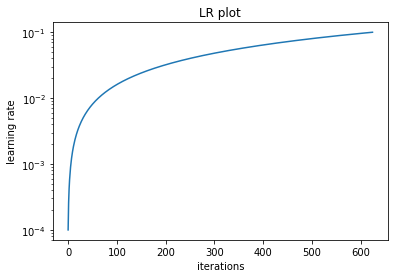

In [6]:
def get_triangular_learning_rate(iteration, stepsize, base_lr,  max_lr):
    
    cycle = np.floor(1 + iteration/(2  * stepsize))
    x = np.abs(iteration/stepsize - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    
    return lr

num_iterations = len(trainloader)  
stepsize = len(trainloader)
max_lr = 0.1     # max learning rate
base_lr = 0.0001  # min learning rate
lr_array = []

for iteration in range(num_iterations):
    
    lr = get_triangular_learning_rate(iteration, stepsize, base_lr, max_lr)
    lr_array.append(lr)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title = 'LR plot', xlabel = 'iterations', ylabel = 'learning rate', yscale = 'log')
ax.plot(lr_array)

### Denoising Autoencoder ###

In [7]:
class Encoder(nn.Module):
    
    def __init__(self):
        
        super(Encoder, self).__init__()
        
        # Encoder
        
        self._layer1 = nn.Sequential(nn.Conv2d(3, 64, 3, 1, 1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     nn.Dropout2d(0.3),
                                     nn.Conv2d(64, 64, 3, 1, 1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2))
        
        
        self._layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.Dropout2d(0.3),
                                     nn.Conv2d(128, 128, 3, 1, 1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2))
                                     
            
        self._layer3 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU(),
                                     nn.Dropout2d(0.3),
                                     nn.Conv2d(256, 256, 3, 1, 1),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU())
                            
            
        self._layer4 = nn.Sequential(nn.Conv2d(256, 512, 3, 1, 1),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU(),
                                     nn.Dropout2d(0.3),
                                     nn.Conv2d(512, 512, 3, 1, 1),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2))
        
    def forward(self, x):
                                   
        x = self._layer1(x)
        x = self._layer2(x)
        x = self._layer3(x)
        x = self._layer4(x)

        return x

In [8]:
class Decoder(nn.Module):
    
    def __init__(self):
        
        super(Decoder, self).__init__()
        
        # Decoder
        
        self._layer1 = nn.Sequential(nn.ConvTranspose2d(512, 256, 3, 2, 1, 1),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU(),
                                     nn.Dropout2d(0.3),
                                     nn.ConvTranspose2d(256, 256, 3, 1, 1),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU())
        
        self._layer2 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.Dropout2d(0.3),
                                     nn.ConvTranspose2d(128, 128, 3, 1, 1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU())
                                     
                                     
            
        self._layer3 = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     nn.Dropout2d(0.3),
                                     nn.ConvTranspose2d(64, 64, 3, 1, 1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU())
                            
            
        self._layer4 = nn.Sequential(nn.ConvTranspose2d(64, 3, 3, 1, 1),
                                     nn.BatchNorm2d(3),
                                     nn.ReLU())
                                     
        
    def forward(self, x):

        x = self._layer1(x)
        x = self._layer2(x)
        x = self._layer3(x)
        x = self._layer4(x)

        return x

In [9]:
def fit(encoder, decoder, optimizer, **kwargs):
    

    
    torch.manual_seed(40)
    torch.cuda.manual_seed(40)
    
    criterion = nn.MSELoss().to(cuda0)
    
    running_loss = 0
    
    noise_factor = 0.1
    
    batch_wise_loss = []
    
    for i, (images, labels) in enumerate(kwargs['dataloader']):
        
        # Adding random noise to images
        noisy_images = images + noise_factor * torch.randn(images.size())
        torch.clamp(noisy_images, 0, 1)
        
        
        # Loading data to GPU
        Noisy_images = noisy_images.to(cuda0)
        Images = images.to(cuda0)
        Labels = labels.to(cuda0)
        
        encoder_output = encoder(Noisy_images)
        generated_images = decoder(encoder_output)
        
        loss = criterion(generated_images, Images)
        
        running_loss += loss.item()
        
        batch_wise_loss.append(loss.item())
        
        parameters = list(encoder.parameters())+ list(decoder.parameters())
        
        # Varying learning rate if lr_finder is used
        if kwargs['lr_finder'] == True:
            
            optimizer = optim.Adam(parameters, lr = kwargs['lr_range_val'][i])
            
        
        if kwargs['phase'] == 'Training':
            #Backward
            optimizer.zero_grad()
            loss.backward()

            #Update weights
            optimizer.step()
          
    return running_loss/len(kwargs['dataloader']), batch_wise_loss

In [10]:

encoder = Encoder().to(cuda0)
decoder = Decoder().to(cuda0)

parameters = list(encoder.parameters())+ list(decoder.parameters())

learning_rate = 0.001    # Dummy learning rate given before using lr finder

optimizer = optim.Adam(parameters, lr = learning_rate)


In [11]:
def lr_finder(lr_array, batchloss):
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set(title='lr finder', xlabel='learning rate', ylabel='loss', xscale='log')
    ax1.plot(lr_array, batch_loss)

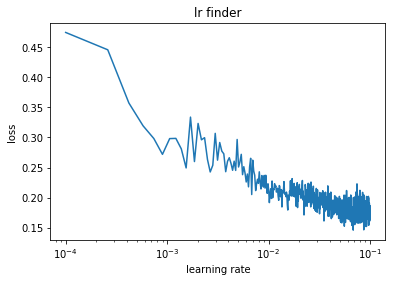

In [12]:
# Training the network for 1 epoch to find the optimal learning rate
_, batch_loss = fit(encoder, decoder, optimizer, dataloader = trainloader,  phase = 'Training', lr_range_val = lr_array, lr_finder = True)  # Training set accuracy

lr_finder(lr_array, batch_loss)

In [12]:
train_loss_values = []
train_acc_values = []


least_loss = 100

learning_rate = 0.01    # Optimal learning rate using lr finder

optimizer = optim.Adam(parameters, lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience =1)

for epoch in range(25):
    
    train_loss, _ = fit(encoder, decoder, optimizer, dataloader = trainloader,  phase = 'Training', lr_range_val = [], lr_finder = False)  # Training set accuracy
    train_loss_values.append(train_loss)

    
    if train_loss < least_loss:
        least_loss = train_loss
        encoder_checkpoint = copy.deepcopy(encoder.state_dict())
        decoder_checkpoint = copy.deepcopy(decoder.state_dict())
        
    #if epoch % 5 ==0:
    print(f'Epoch: {epoch}   Train Loss: {train_loss:.5f} ')
        
    scheduler.step(train_loss)

Epoch: 0   Train Loss: 0.17662 
Epoch: 1   Train Loss: 0.15886 
Epoch: 2   Train Loss: 0.15483 
Epoch: 3   Train Loss: 0.15242 
Epoch: 4   Train Loss: 0.15117 
Epoch: 5   Train Loss: 0.15041 
Epoch: 6   Train Loss: 0.15003 
Epoch: 7   Train Loss: 0.14972 
Epoch: 8   Train Loss: 0.14934 
Epoch: 9   Train Loss: 0.14898 
Epoch: 10   Train Loss: 0.14873 
Epoch: 11   Train Loss: 0.14865 
Epoch: 12   Train Loss: 0.14834 
Epoch: 13   Train Loss: 0.14825 
Epoch: 14   Train Loss: 0.14823 
Epoch: 15   Train Loss: 0.14803 
Epoch: 16   Train Loss: 0.14790 
Epoch: 17   Train Loss: 0.14773 
Epoch: 18   Train Loss: 0.14756 
Epoch: 19   Train Loss: 0.14746 
Epoch: 20   Train Loss: 0.14729 
Epoch: 21   Train Loss: 0.14707 
Epoch: 22   Train Loss: 0.14698 
Epoch: 23   Train Loss: 0.14692 
Epoch: 24   Train Loss: 0.14682 


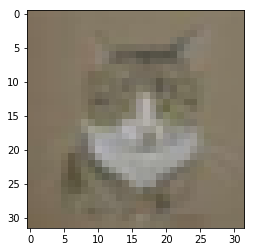

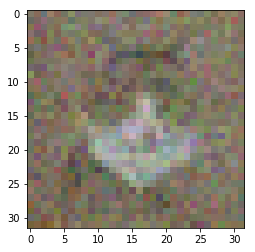

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1,2,0) ))
    
# Plotting original image 
imshow(images[0])   
plt.show()

# Adding noise to images
noisy_images = images + 0.1 * torch.randn(images.size())
torch.clamp(noisy_images, 0, 1)

# Plotting noisy image
imshow(noisy_images[0])

torch.Size([64, 3, 32, 32])


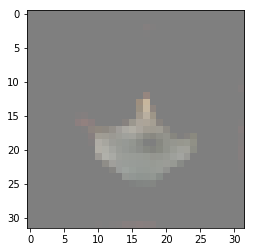

In [14]:
print(noisy_images.size())
encoded_image = encoder(noisy_images.to(cuda0))
output = decoder(encoded_image)

# Plotting output from autoencoder
imshow(output[0].cpu().detach())

### Classification using latent space ###
For classification using the latent space, a new classifier model is built using the pre-trained encoder network with additional conv layers and global average pooling added at the end to output the class labels. <br>
The data is split into training and validation and the error is measured using the binary cross-entropy loss.

In [15]:
pretrained_encoder = Encoder()
pretrained_encoder.load_state_dict(encoder_checkpoint) # Loading the trained weights for encoder


In [16]:
class Classifier(nn.Module):
    
    
    def __init__(self, pretrained_encoder):
        
        super(Classifier, self).__init__()
        
        self._encoder_model = pretrained_encoder
        
        self._output_layer = nn.Sequential(nn.Conv2d(512, 256, 3, 1, 1),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU(),
                                     nn.Dropout2d(0.3),
                                     nn.Conv2d(256, 128, 3, 1, 1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.Dropout2d(0.3),
                                     nn.Conv2d(128, 10, 3, 1, 1),
                                     nn.BatchNorm2d(10),
                                     nn.ReLU())
        
    def forward(self, x):
        
        x = self._encoder_model(x)
        

        x = self._output_layer(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        
        return x.squeeze()

In [17]:
def train(encoder_classifier, optimizer, **kwargs):
    
    if kwargs['phase'] == 'Training':
        encoder_classifier.train()
        
    if kwargs['phase'] == 'Validation':
        encoder_classifier.eval()
     
    
    criterion = nn.CrossEntropyLoss().to(cuda0)
    
    running_loss = 0
    running_pred = 0
    
    batch_wise_loss = []
    
    for i, (images, labels) in enumerate(kwargs['dataloader']):
        
        
        Images = images.to(cuda0)
        Labels = labels.to(cuda0)
        
        y_pred = encoder_classifier(Images)
        Labels = Labels
        
        loss = criterion(y_pred, Labels)
        
        running_loss += loss.item()
        
        batch_wise_loss.append(loss.item())
        
        # Varying learning rate if lr_finder is used
        if kwargs['lr_finder'] == True:
            
            optimizer = optim.Adam(encoder_classifier.parameters(), lr = kwargs['lr_range_val'][i])
            
        
        if kwargs['phase'] == 'Training':
            
            #Backward
            optimizer.zero_grad()
            loss.backward()

            #Update weights
            optimizer.step()
            
            
        # Finding the number of correct predictions in the training set
        _, pred_class = torch.max(y_pred.data, 1)
       
        running_pred += (pred_class.cpu() == Labels.data.cpu()).sum()


    acc = 100. * (running_pred.numpy()/len(kwargs['dataloader'].sampler))
          
    return running_loss/len(kwargs['dataloader']), acc, batch_wise_loss

In [18]:
encoder_classifier = Classifier(pretrained_encoder).to(cuda0)

learning_rate = 0.001

optimizer = optim.Adam(encoder_classifier.parameters(), lr = learning_rate)

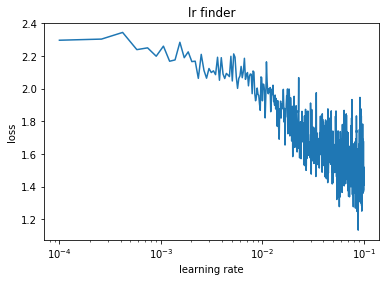

In [19]:
# Using lr finder to find the optimal learning rate for the fc layers
_, _, batch_loss = train(encoder_classifier, optimizer, dataloader = trainloader,  phase = 'Training', lr_range_val = lr_array, lr_finder = True)  # Training set accuracy
lr_finder(lr_array, batch_loss)

In [24]:
train_loss_values = []
train_acc_values = []

val_loss_values = []
val_acc_values = []

best_acc = 0

learning_rate = 0.01    # Optimal learning rate using lr finder

optimizer = optim.Adam(encoder_classifier._output_layer.parameters(), lr = learning_rate, weight_decay = 0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience =2)

for epoch in range(150):   
    
    train_loss, train_acc, _ = train(encoder_classifier, optimizer, dataloader = trainloader,  phase = 'Training', lr_range_val = [], lr_finder = False)  # Training set accuracy
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    val_loss, val_acc, _ = train(encoder_classifier, optimizer, dataloader = valloader,  phase = 'Validation', lr_range_val = [], lr_finder = False)  # Training set accuracy
    val_loss_values.append(val_loss)
    val_acc_values.append(val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        classifier_model_checkpoint = copy.deepcopy(encoder_classifier.state_dict())
        
    
    scheduler.step(val_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}  Train Loss: {train_loss:.5f}  Train Acc:{train_acc:.5f}%\
    Val Loss: {val_loss:.5f}  Val Acc:{val_acc:.5f}% ')


Epoch: 0  Train Loss: 1.04747  Train Acc:62.79250%    Val Loss: 1.12539  Val Acc:59.65000% 
Epoch: 10  Train Loss: 1.19359  Train Acc:58.05000%    Val Loss: 0.98524  Val Acc:64.69000% 
Epoch: 20  Train Loss: 1.05550  Train Acc:62.91500%    Val Loss: 0.88976  Val Acc:69.20000% 
Epoch: 30  Train Loss: 1.00077  Train Acc:65.08000%    Val Loss: 0.86408  Val Acc:69.80000% 
Epoch: 40  Train Loss: 0.95639  Train Acc:66.69750%    Val Loss: 0.84457  Val Acc:70.51000% 
Epoch: 50  Train Loss: 0.90774  Train Acc:68.41250%    Val Loss: 0.83051  Val Acc:71.01000% 
Epoch: 60  Train Loss: 0.90847  Train Acc:68.52000%    Val Loss: 0.82918  Val Acc:70.97000% 
Epoch: 70  Train Loss: 0.91015  Train Acc:68.40000%    Val Loss: 0.82557  Val Acc:71.21000% 
Epoch: 80  Train Loss: 0.90363  Train Acc:68.73250%    Val Loss: 0.83077  Val Acc:71.04000% 
Epoch: 90  Train Loss: 0.90745  Train Acc:68.52750%    Val Loss: 0.83044  Val Acc:71.16000% 
Epoch: 100  Train Loss: 0.90594  Train Acc:68.70500%    Val Loss: 0.828

In [25]:
# Function to get predictions for test data and the accuracy on it
def predict(model, testloader):
    
    model.eval()
    pred_val = 0
    prediction_array = np.array([])
    labels_array = np.array([])
    
    for images, labels in testloader:
        

        # Feeding data to GPU 
        
        Images = images.to(cuda0)
        Labels = labels.to(cuda0)


        #Forward
        pred = model(Images)
        
        # Finding the number of correct predictions in the training set
        _, pred_label = torch.max(pred.data, 1)

        pred_val += (pred_label.cpu() == Labels.data.cpu()).sum()
        
        # Storing predictions and true labels in numpy arrays for printing confusion matrix
        prediction_array = np.append(prediction_array, pred_label.cpu().numpy(), axis =0)
        labels_array = np.append(labels_array, Labels.data.cpu().numpy(), axis = 0)


    Test_acc = 100. * (pred_val.numpy()/len(testloader.dataset))
    return Test_acc, prediction_array, labels_array
    

In [26]:
encoder_classifier.load_state_dict(classifier_model_checkpoint)
torch.save(encoder_classifier.state_dict(), "VAE_model.th")

In [27]:
Test_acc, Predicted_labels, True_labels = predict(encoder_classifier, testloader) # Test set accuracy

print(f'Test Accuracy:{Test_acc:.5f}% ')

Test Accuracy:69.64000% 


In [28]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(True_labels, Predicted_labels)
print(cm)

[[764  22  52  10  11   7   9  11  75  39]
 [ 13 872   2   5   3   2   8   6  20  69]
 [ 79   9 551  84  83  75  63  32  14  10]
 [ 28  11  59 464  61 190  92  45  24  26]
 [ 32   8  90  74 575  47  74  90   9   1]
 [ 17   5  64 170  39 604  25  63   5   8]
 [  9   6  36  58  41  29 792   7  17   5]
 [ 20   3  33  42  47  80  10 747   4  14]
 [ 66  37  10  18   5   4   5   6 819  30]
 [ 31  99   5  24   0   6  13  15  31 776]]


['with_ball', 'without_ball']


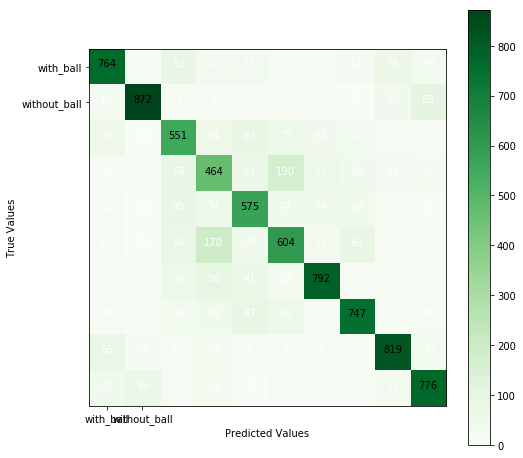

In [29]:
# Plotting confusion matrix
import itertools
def plot_confusion_matrix(cm, classes):
    
    cmap = plt.get_cmap('Greens')
    plt.figure(figsize=(8,8))
    plt.imshow(cm, cmap = cmap, interpolation = 'nearest')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    print(classes)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    
    threshold = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(i, j, f'{cm[i, j]}' , horizontalalignment = 'center', 
                 color="white" if cm[i, j] < threshold else "black")

plot_confusion_matrix(cm.T, ['with_ball', 'without_ball'])